In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

In [3]:
NUM_CLASSES = 11

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 11)                121       
                                                                 
Total params: 1191 (4.65 KB)
Trainable params: 1191 (4.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

In [11]:

val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 5ms/step - loss: 2.5051 - accuracy: 0.0640


In [12]:

model = tf.keras.models.load_model(model_save_path)

In [13]:

predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 107ms/step
[3.6238063e-12 1.3967047e-16 6.5881127e-01 1.3392757e-09 1.8517340e-13
 1.4472887e-03 2.9858382e-10 2.6110492e-17 3.3972323e-01 1.8269177e-05
 3.5625295e-13]
2


10/10 [==============================] - 0s 3ms/step


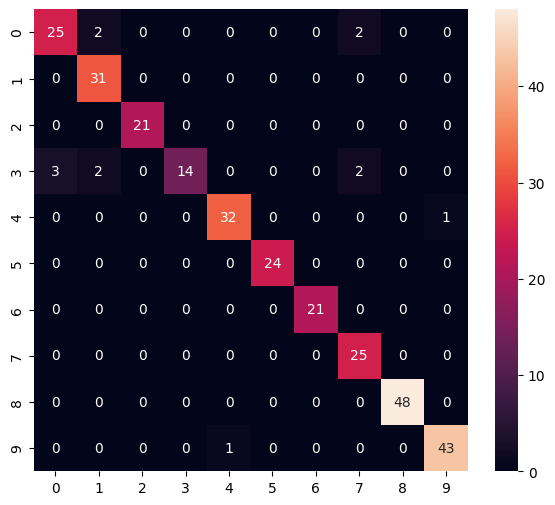

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.89      1.00      0.94        31
           2       1.00      1.00      1.00        21
           3       1.00      0.67      0.80        21
           4       0.97      0.97      0.97        33
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        21
           7       0.86      1.00      0.93        25
           8       1.00      1.00      1.00        48
           9       0.98      0.98      0.98        44

    accuracy                           0.96       297
   macro avg       0.96      0.95      0.95       297
weighted avg       0.96      0.96      0.95       297



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [15]:
from sklearn.metrics import accuracy_score
model.save(model_save_path, include_optimizer=False)

c:\Users\hhema\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3080: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:

tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\hhema\AppData\Local\Temp\tmp85nux63e\assets


INFO:tensorflow:Assets written to: C:\Users\hhema\AppData\Local\Temp\tmp85nux63e\assets


6852

In [17]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [18]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [19]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [20]:
%%time

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [21]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.6238076e-12 1.3967051e-16 6.5881145e-01 1.3392759e-09 1.8517344e-13
 1.4472897e-03 2.9858391e-10 2.6110401e-17 3.3972299e-01 1.8269180e-05
 3.5625306e-13]
2
